In [1]:
from puff_model_v2 import puff_model
import torch
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline 
from unit_conversion import convert_wind


#### Test Case 1: downward wind, two sources and one active - sensors below. Data is noisy-ish, bc i'm eyeballing sensor vals

In [2]:
data_dir = f"{os.getcwd()}/data"
# load in data
df_wind_ch4 = pd.read_csv(data_dir + "/wind_ch4.csv")

df_true_emission = pd.read_csv(data_dir + "/selected_controll_release.csv")
source_points = torch.tensor(np.load(data_dir + "/source_points.npy")) # shape=(n_source, 3)
sensor_points = torch.tensor(np.load(data_dir + "/sensor_points.npy")) # shape=(n_sensor, 3)
#col_points = np.load(data_dir + "/col_points.npy")  # shape=(n_col, 3)
df_bounds = pd.read_csv(data_dir + "/bounds.csv", dtype='float32')
df_puff_simulation = pd.read_csv(data_dir + '/df_obs_20220502008_0.csv').fillna(0.)

tfinal = 5*60.
source_location = torch.tensor(source_points)

ws = df_wind_ch4['wind_speed.m/s'].to_numpy() # shape=(N_t,)
wd = df_wind_ch4['wind_direction'].to_numpy() # shape=(N_t,)
df_puff_simulation['x'], df_puff_simulation['y'] = convert_wind(ws,wd)


wind_function_x = lambda t : torch.tensor(CubicSpline(df_puff_simulation.index*60,df_puff_simulation.x)(t))
wind_function_y = lambda t : torch.tensor(CubicSpline(df_puff_simulation.index*60,df_puff_simulation.y)(t))

# sensor_names = ['N','W','SW','S','SE','E','NE','C1','NW']
sensor_names = ['N','E','SE','S','SW','W','NW','C1','NE']

num_sensors = len(sensor_names)
df_sensor = pd.DataFrame(sensor_points,columns = ['x','y','z'])
df_sensor['name'] = sensor_names
sensor_locations = df_sensor[['x','y','z']].to_numpy()
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = lambda t, f = CubicSpline(df_puff_simulation.index*60,df_puff_simulation[name]) : torch.tensor(f(t))
# ch4 = np.transpose(df_wind_ch4.iloc[:, 3:].to_numpy()) # shape=(N_obs, N_t)
sensor_names = df_wind_ch4.columns[3:]

C:\Users\andyh\AppData\Local\Temp\ipykernel_4012\2752204143.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_location = torch.tensor(source_points)


#### Create observation data matrix of 100 obs across domain of 45 min


In [3]:
num_obs = 50
tbegin = 0*60
tend = 45*60
# source_location[0,2] = 2
obs_t = torch.linspace(tbegin,tend,num_obs)
obs = torch.zeros(num_obs, num_sensors)
obs += torch.rand(obs.shape)*0
for i in range(num_obs):
    for j in range(num_sensors):
        obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i]))


C:\Users\andyh\AppData\Local\Temp\ipykernel_4012\3778235351.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i]))


In [4]:

pm = puff_model(source_location,sensor_points, [3, 3, 1], wind_function_x, wind_function_y,[1,1],1)
Q_torch, p_torch, M_torch = pm.return_qp_matrices_new(obs,obs_t,spread=True)


In [5]:
def lasso(f,num_nz,bias=False):
    alpha = 1
    alpha_old = 0
    expand = True
    num = 0
    iter = 0
    while num != num_nz and abs(alpha_old - alpha) > .000001:
        x = f(alpha)
        if bias == True:
            x = x[:-1]
        print(x)
        num = torch.sum((torch.abs(x)>1e-3).int())
        # print(num)
        if num > num_nz:
            temp = alpha
            alpha += 10**iter if expand else abs(alpha_old - alpha)/2
            alpha_old = temp
        elif num < num_nz:
            temp = alpha
            alpha -= abs(alpha_old - alpha)/2
            alpha_old = temp
            # print(2,alpha)
        iter+=1
        if alpha < alpha_old:
            expand = False
    return alpha

In [6]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
def constrained_lsq_solve(Q,p,G,h,bias=False):
    p = p.view(-1,1)
    # if bias:
    #     p = torch.cat([p,torch.tensor([[0]])])
    #     print(p)
    #     Q = torch.cat([Q,torch.zeros(Q.shape[1]).view(1,-1)])
    #     Q = torch.cat([Q,torch.zeros(Q.shape[0]).view(-1,1)],dim=1)
    #     Q[-1,-1] = 1
    #     # print(torch.tensor([1 if i == G.shape[1] - 1 else 0 for i in range(G.shape[1])]).view(1,-1))
    #     G = torch.cat([G,torch.zeros(G.shape[0]).view(-1,1)],dim=1)
    #     G = torch.cat([G,torch.tensor([-1 if i == G.shape[1] - 1 else 0 for i in range(G.shape[1])]).view(1,-1)])
    #     h = torch.cat([h,torch.tensor([0])])
    #     print(torch.linalg.matrix_rank(G))
    Q = matrix(Q.detach().numpy().astype(np.double))
    p = matrix(p.detach().numpy().astype(np.double))
    G = matrix(G.detach().numpy().astype(np.double))
    h = matrix(h.detach().numpy().astype(np.double))
    return torch.tensor(np.array(solvers.qp(Q,p,G,h)['x'],dtype=np.float64)).float()

In [7]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
sparse_coef = .275*torch.norm(p_torch,1)
bias = True
# sparse_coef = 0
p = p_torch.view(-1,1)
Q = Q_torch
if bias:
    M_torch = torch.cat([M_torch,torch.ones(M_torch.shape[0],1)],dim=1)
    p = -2*(obs.T.reshape(1,-1)@M_torch).reshape(-1,1)
    Q = M_torch.T@M_torch

print(p.shape)
#only constrain non-negativity
G = torch.cat([-1*torch.eye(len(p))])
h = torch.cat([torch.zeros(len(p))])

def f(alpha):
    pp = p + alpha*torch.ones(len(p),1).reshape(-1,1)
    pp[-1,-1] -= alpha
    return constrained_lsq_solve(Q,pp,G,h,bias=bias)
alpha = lasso(f,1,bias=bias)
print(alpha)

torch.Size([6, 1])
tensor([[8.8459e-05],
        [9.1130e-05],
        [9.6953e-05],
        [8.1258e-05],
        [7.1541e-05]])
tensor([[1.0350e-04],
        [1.0670e-04],
        [1.1370e-04],
        [9.4887e-05],
        [8.3303e-05]])
tensor([[3.2455e-06],
        [4.4556e-06],
        [1.4883e-05],
        [1.8528e-06],
        [1.2234e-06]])
tensor([[1.9858e-05],
        [4.3135e-04],
        [1.1866e+03],
        [3.4659e-05],
        [1.4445e-05]])
0.125


In [8]:
print(p.shape)

torch.Size([6, 1])


In [9]:
p_torch_n = alpha*torch.ones(p.shape) +p
if bias:
    p_torch_n[-1,-1] -= alpha
print(p_torch_n.shape)

x = constrained_lsq_solve(Q,p_torch_n,G,h,bias=bias)
print(x)
filter = x.reshape(-1) < 1e-3
# p = p_torch_n.reshape(-1,1)
print(p.shape)
if bias:
    filter[-1] = False
print(filter)
G = torch.cat([G,torch.eye(len(filter))[filter]])
h = torch.cat([h.reshape(-1),torch.zeros(torch.sum(filter))])
x = constrained_lsq_solve(Q,p,G,h,bias=bias)
print(x)


torch.Size([6, 1])
tensor([[1.9858e-05],
        [4.3135e-04],
        [1.1866e+03],
        [3.4659e-05],
        [1.4445e-05],
        [4.3713e+00]])
torch.Size([6, 1])
tensor([ True,  True, False,  True,  True, False])
tensor([[-2.0700e-12],
        [ 1.8174e-14],
        [ 2.8929e+03],
        [ 5.6579e-13],
        [ 5.0452e-13],
        [ 3.9422e+00]])


In [10]:
print(x)
for i in range(len(x)):
    print(i+1,torch.norm(M_torch[:,i]- obs.T.reshape(-1,1),2))

tensor([[-2.0700e-12],
        [ 1.8174e-14],
        [ 2.8929e+03],
        [ 5.6579e-13],
        [ 5.0452e-13],
        [ 3.9422e+00]])
1 tensor(1441.7358)
2 tensor(1441.7245)
3 tensor(1441.7354)
4 tensor(1441.8146)
5 tensor(1441.7428)
6 tensor(1155.7479)


In [11]:
M = M_torch
print(np.linalg.norm(np.array(M)@np.array(x) - obs.T.reshape(-1,1).detach().numpy(),2))
noise = np.random.rand(x.shape[0],1)*100-50
print(np.linalg.norm(np.array(M)@(np.array(x)+noise) - obs.T.reshape(-1,1).detach().numpy(),2))
print(np.linalg.norm(np.array(M)@(np.ones(x.shape)) - obs.T.reshape(-1,1).detach().numpy(),2))


67.9679
210.6115564042779
54.46562358778054


C:\Users\andyh\AppData\Local\Temp\ipykernel_4012\2160424561.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm')  # red to blue


(-3.0, 3.0)

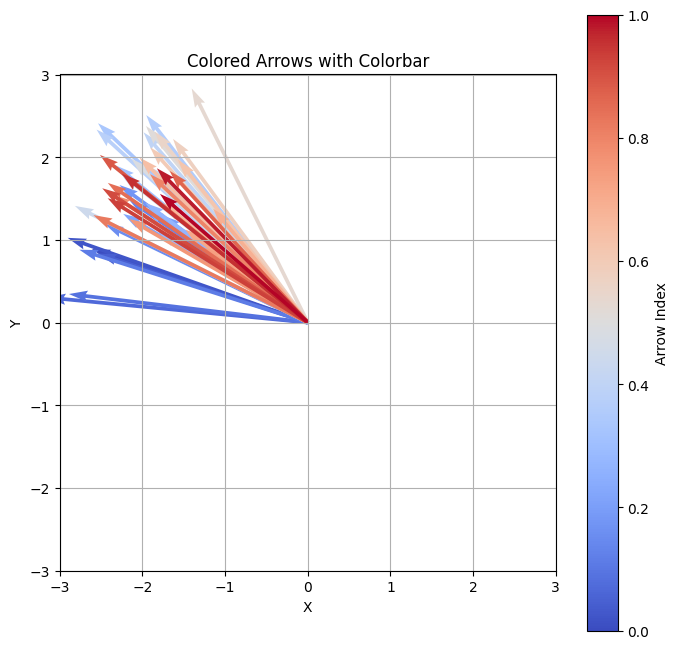

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def plot_colored_arrows(wd, ws, origin_x=0, origin_y=0, color_by='index'):
    wd = np.array(wd)
    ws = np.array(ws)
    n = len(wd)
    assert wd.shape == ws.shape, "Angle and magnitude arrays must match"

    # Compute vector components
    theta = np.deg2rad(wd)
    u = ws * np.cos(theta)
    v = ws * np.sin(theta)

    # Starting positions
    x0 = np.full_like(u, origin_x)
    y0 = np.full_like(v, origin_y)

    # Values to color by (either index or magnitude)
    if color_by == 'index':
        color_values = np.linspace(0, 1, n)
        label = "Arrow Index"
    elif color_by == 'magnitude':
        color_values = (ws - ws.min()) / (ws.max() - ws.min() + 1e-8)
        label = "Magnitude"
    else:
        raise ValueError("color_by must be 'index' or 'magnitude'")

    cmap = get_cmap('coolwarm')  # red to blue
    norm = Normalize(vmin=0, vmax=1)

    # Create quiver plot
    fig, ax = plt.subplots(figsize=(8, 8))
    q = ax.quiver(x0, y0, u, v, color_values, cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1)

    # Add colorbar
    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label)

    ax.set_aspect('equal')
    ax.set_title("Colored Arrows with Colorbar")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

plot_colored_arrows(wd, ws)
plt.xlim(-3,3)
plt.ylim(-3,3)

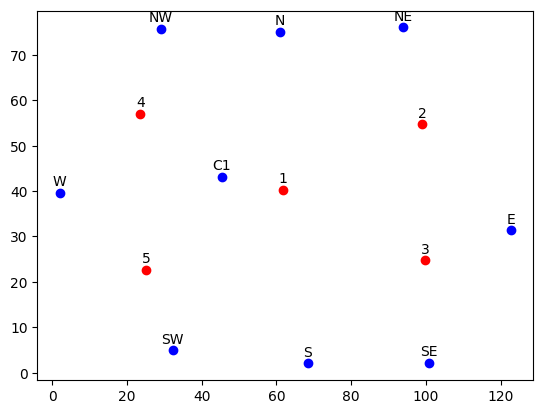

In [13]:
fig,ax = plt.subplots()
ax.scatter(source_location[:,0],source_location[:,1],color='red')
ax.scatter(sensor_points[:,0],sensor_points[:,1],color='blue')

labels = df_sensor['name']
for i, label in enumerate(labels):
    plt.annotate(label, (df_sensor.x[i], df_sensor.y[i]), textcoords="offset points", xytext=(0,5), ha='center')
for i in range(len(source_location)):
    plt.annotate(str(i+1), (source_location[i,0],source_location[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

In [14]:
print(sensor_values_fn['NW'](16))

tensor(2.0335, dtype=torch.float64)


In [15]:
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = interp1d(df_puff_simulation.index*60,df_puff_simulation[name])

sensor_values_fn_1 = dict()
for name in sensor_names:
    sensor_values_fn_1[name] = lambda t,x=sensor_values_fn[name] : torch.tensor(x(t))



print(sensor_values_fn['C1'](24*60))
print(sensor_values_fn_1['C1'](24*60))
print(M_torch)

0.0
tensor(0., dtype=torch.float64)
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.5318e-07, 1.4390e-03, 2.8124e-05, 2.3345e-14, 4.8627e-16, 1.0000e+00],
        [1.9448e-06, 1.5868e-03, 6.5698e-05, 8.6319e-13, 2.7167e-14, 1.0000e+00],
        ...,
        [7.9158e-11, 7.0776e-04, 1.0485e-05, 4.0388e-20, 2.9709e-19, 1.0000e+00],
        [1.4159e-09, 1.2112e-03, 5.0653e-05, 3.3545e-18, 4.4302e-17, 1.0000e+00],
        [6.2304e-09, 1.2148e-03, 7.9740e-05, 1.8054e-16, 2.9879e-15, 1.0000e+00]])


C:\Users\andyh\AppData\Local\Temp\ipykernel_4012\2943531431.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


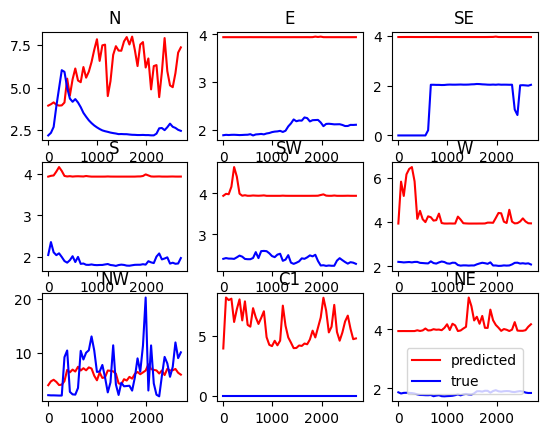

In [16]:
fig, ax  = plt.subplots(3,3)
i=0
for i in range(num_sensors):
    ax[i//3,i%3].set_title(sensor_names[i])
    tt = obs_t
    ax[i//3,i%3].plot(obs_t,(M_torch[num_obs*i:(num_obs*(i+1)),:]@x).view(-1) ,color='red',label='predicted')
    ax[i//3,i%3].plot(obs_t,sensor_values_fn[sensor_names[i]](tt),color='blue',label='true')
    plt.legend()
    